In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
%matplotlib inline

In [39]:
df_freight = pd.read_csv('data/freight_cost.csv')
df_oil = pd.read_csv('data/monthly_oil_cost_1988-2025.csv')

In [40]:
df_freight = df_freight.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis=1)
df_freight["Date"] = pd.to_datetime(df_freight["Date"], format="%m/%d/%Y").dt.strftime("%d/%m/%Y")

df_oil = df_oil.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis=1)
df_oil["Date"] = pd.to_datetime(df_oil["Date"], format="%m/%d/%Y").dt.strftime("%d/%m/%Y")

df_freight.head(5)
df_oil.head(10)

,Date,Price
0,01/03/2025,70.88
1,01/02/2025,72.81
2,01/01/2025,75.67
3,01/12/2024,74.24
4,01/11/2024,71.84
5,01/10/2024,72.81
6,01/09/2024,71.77
7,01/08/2024,76.93
8,01/07/2024,80.84
9,01/06/2024,85.00


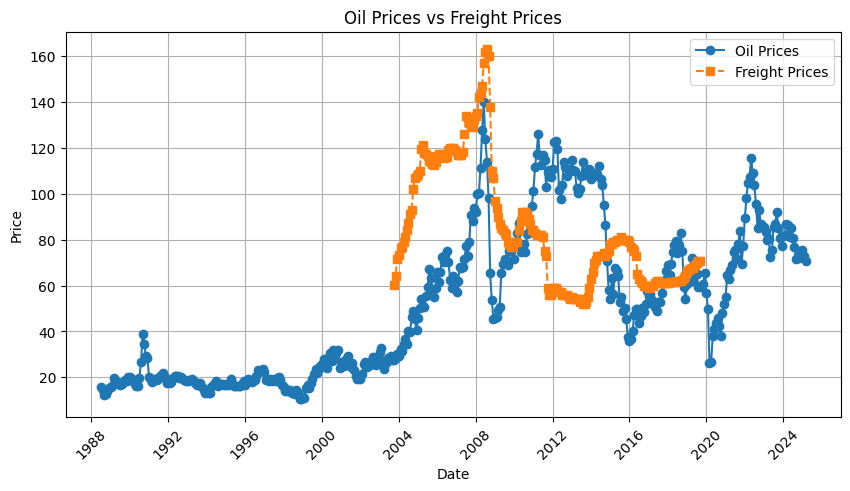

In [41]:
df_oil["Date"] = pd.to_datetime(df_oil["Date"], format="%d/%m/%Y")
df_freight["Date"] = pd.to_datetime(df_freight["Date"], format="%d/%m/%Y")

df_oil = df_oil.sort_values(by="Date")
df_freight = df_freight.sort_values(by="Date")

# Строим график
plt.figure(figsize=(10, 5))
plt.plot(df_oil["Date"], df_oil["Price"], marker="o", linestyle="-", label="Oil Prices")
plt.plot(df_freight["Date"], df_freight["Price"], marker="s", linestyle="--", label="Freight Prices")

# Оформление
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Oil Prices vs Freight Prices")
plt.legend()
plt.grid()

# Показать график
plt.xticks(rotation=45)
plt.show()

In [42]:
merged_df = pd.merge(df_oil, df_freight, on="Date", suffixes=("_Oil", "_Freight"))

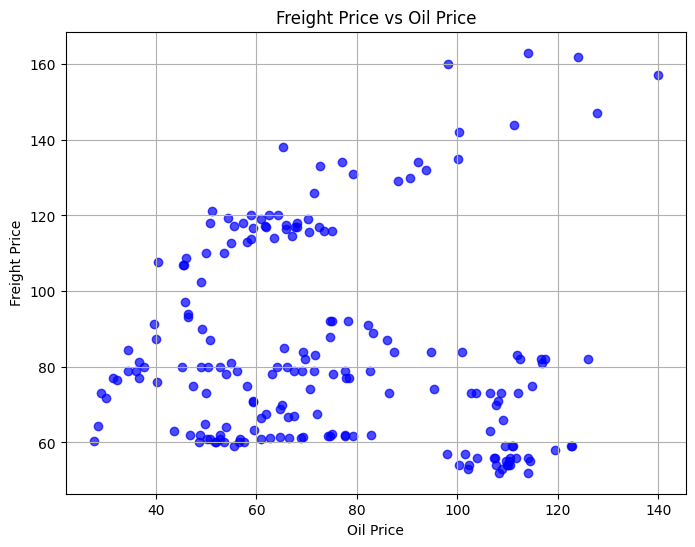

In [43]:
plt.figure(figsize=(8, 6))
plt.scatter(merged_df["Price_Oil"], merged_df["Price_Freight"], color="b", alpha=0.7)

# Оформление
plt.xlabel("Oil Price")
plt.ylabel("Freight Price")
plt.title("Freight Price vs Oil Price")
plt.grid(True)

# Показать график
plt.show()

<Axes: >

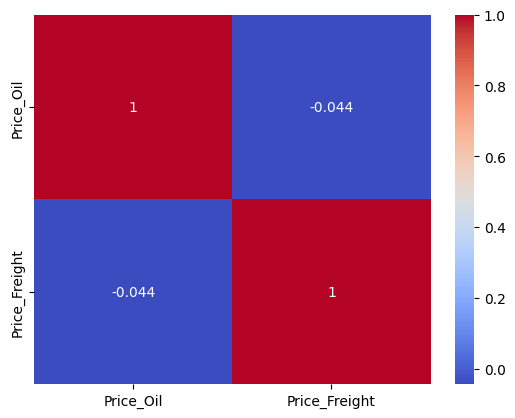

In [ ]:
import seaborn as sns
# sns.heatmap(merged_df.drop('Date', axis=1).corr(), annot=True, cmap='coolwarm',)

In [55]:
np.cov(merged_df.drop(['Date'],axis=1).T)

array([[676.71837582, -30.61463295],
       [-30.61463295, 713.35830854]])

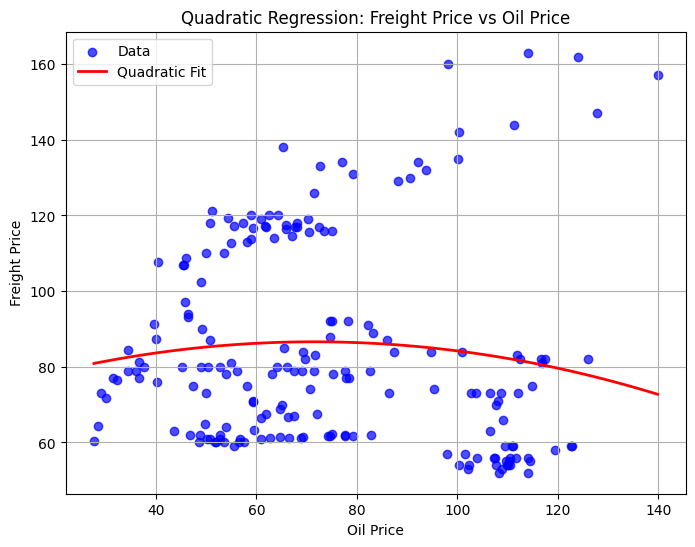

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Price_Freight   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.6922
Date:                Thu, 20 Mar 2025   Prob (F-statistic):              0.502
Time:                        16:43:13   Log-Likelihood:                -901.95
No. Observations:                 192   AIC:                             1810.
Df Residuals:                     189   BIC:                             1820.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         71.3786     17.458      4.089      0.000      36.941     105.816
x1             0.4255      0.473      0.899      0.370      -0.508       1.359
x2            -0.0030      0.003     -1.007      0.315      -0.009       0.003
==============================================================================
Omnibus:                       28.557   Durbin-Watson:                   0.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.468
Skew:                           1.044   Prob(JB):                     1.21e-08
Kurtosis:                       3.447   Cond. No.                     6.77e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.77e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [56]:
import numpy as np
import seaborn as sns
import statsmodels.api as sm

# Делаем полиномиальную регрессию 2-й степени (квадратичную)
x = merged_df["Price_Oil"]
y = merged_df["Price_Freight"]

# Добавляем квадратный член
X_poly = np.column_stack((x, x**2))
X_poly = sm.add_constant(X_poly)  # Добавляем константу для свободного члена

# Обучаем модель
model = sm.OLS(y, X_poly).fit()

# Генерируем предсказания
x_range = np.linspace(min(x), max(x), 100)
X_pred = np.column_stack((x_range, x_range**2))
X_pred = sm.add_constant(X_pred)
y_pred = model.predict(X_pred)

# Строим график
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color="b", alpha=0.7, label="Data")
plt.plot(x_range, y_pred, color="r", linewidth=2, label="Quadratic Fit")

# Оформление
plt.xlabel("Oil Price")
plt.ylabel("Freight Price")
plt.title("Quadratic Regression: Freight Price vs Oil Price")
plt.legend()
plt.grid(True)

# Показать график
plt.show()

# Выводим статистику модели
model.summary()

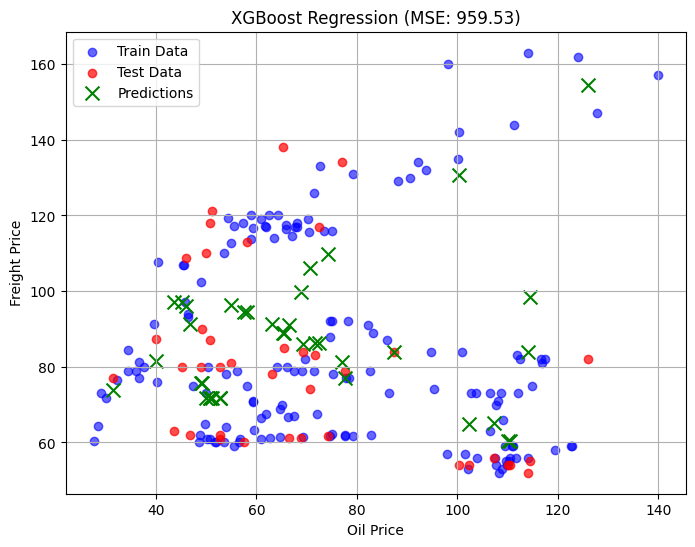

In [57]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Разделение данных на тренировочную и тестовую выборки
X = merged_df[["Price_Oil"]]
y = merged_df["Price_Freight"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение модели XGBoost
xgb_model = XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_pred = xgb_model.predict(X_test)

# Оценка модели
mse = mean_squared_error(y_test, y_pred)

# График предсказаний
plt.figure(figsize=(8, 6))
plt.scatter(X_train, y_train, color="b", alpha=0.6, label="Train Data")
plt.scatter(X_test, y_test, color="r", alpha=0.7, label="Test Data")
plt.scatter(X_test, y_pred, color="g", marker="x", s=100, label="Predictions")

plt.xlabel("Oil Price")
plt.ylabel("Freight Price")
plt.title(f"XGBoost Regression (MSE: {mse:.2f})")
plt.legend()
plt.grid(True)

# Показать график
plt.show()